# Convolutional Layers:

Extract spatial features like edges and patterns.
Use multiple layers with increasing filters (e.g., 32, 64, 128).
Pooling Layers:

Reduce spatial dimensions to make computation more efficient.
Typically, use MaxPooling (e.g., 2x2).
Fully Connected (Dense) Layers:

Map extracted features to character classes.
Activation Functions:

Use ReLU for intermediate layers and softmax for the output layer.



- Compile multiple datasets for more generalization
- Make all dataset grouped and uniformed
- Simple EDA of data
- Make Split Ratio of 65/15/10 Train, Valid, Test (ADD LIMIT FOR LESSER TIME TRAINING)
- Data Augmentation for training data
- Preprocessing of all data
- Optuna Framework for best hyper parameters
- Apply optimal hyperparameters
- Model Evaluation

# Splitting of Dataset

Since the dataset is around 90k+ number of images and has 59 classes, a splitting of dataset is done and a limit for each class was introduced to take into account the training time it will take.

In [15]:
import os

# Define the dataset path
dataset_path = r"D:\WORK\Baybayin App Project\dataset"

# Count all images in the folder and its subfolders
total_images = 0
for root, dirs, files in os.walk(dataset_path):
    total_images += len([f for f in files if f.endswith(('.jpg', '.png'))])

total_images


99833

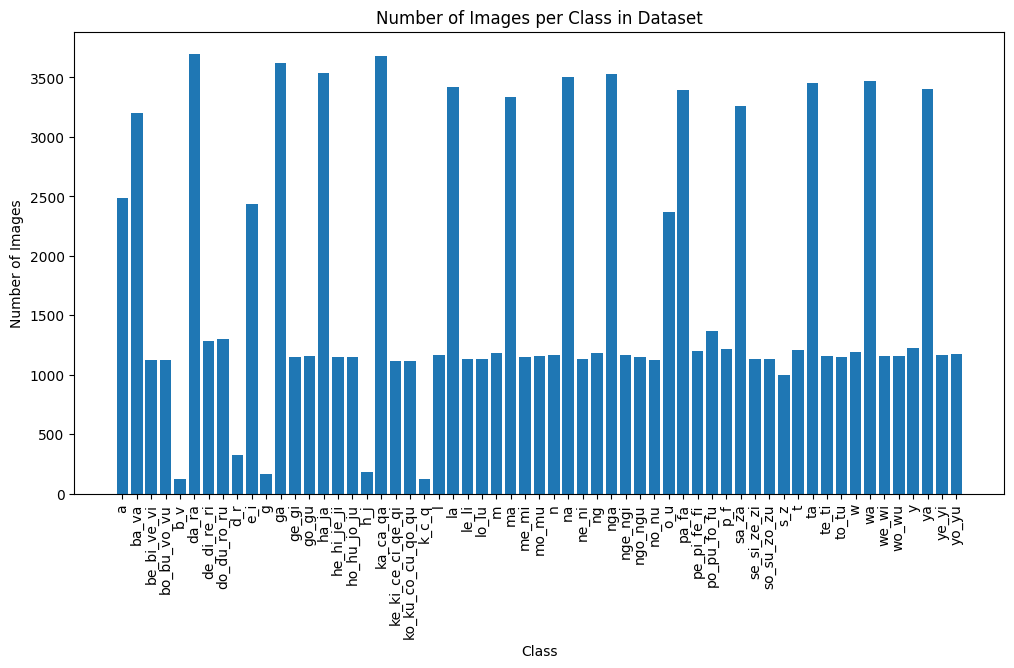

In [16]:
import matplotlib.pyplot as plt

# Initialize a dictionary to store the count of images per class
class_counts = {}

# Iterate through each class directory
for class_name in os.listdir(dataset_path):
  class_path = os.path.join(dataset_path, class_name)
  if os.path.isdir(class_path):
    # Count the number of images in the class directory
    class_counts[class_name] = len([img for img in os.listdir(class_path) if img.endswith(('.jpg', '.png'))])

# Plot the counts
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Dataset')
plt.xticks(rotation=90)
plt.show()

Some classes have low number of images, so a manual check is done and found that the count of images in some classes are not correct.

The dataset has imbalanced number of images in all 59 classes so a manual approach will be used

In [8]:
import os
import random
import shutil

# Define the dataset path and new folder path
dataset_path = "D:/WORK/Baybayin App Project/dataset"
limited_dataset_path = "D:/WORK/Baybayin App Project/limited_dataset"

# Create the new dataset directory if it doesn't exist
os.makedirs(limited_dataset_path, exist_ok=True)

# Iterate through each class directory
for class_name in os.listdir(dataset_path):
  class_path = os.path.join(dataset_path, class_name)
  if os.path.isdir(class_path):
    # Get all image files in the class directory
    images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.jpg', '.png'))]
    
    # Shuffle the images to ensure randomness
    random.shuffle(images)
    
    # Pick the first 1000 images or all if less than 1000
    selected_images = images[:1000]
    
    # Create the class directory in the new dataset path
    new_class_path = os.path.join(limited_dataset_path, class_name)
    os.makedirs(new_class_path, exist_ok=True)
    
    # Copy the selected images to the new class directory
    for img in selected_images:
      shutil.copy(img, new_class_path)

limited_dataset_path

'D:/WORK/Baybayin App Project/limited_dataset'

In [9]:
from sklearn.model_selection import train_test_split
import os
import shutil

# Define the dataset path and new folder path
limited_dataset_path = "D:/WORK/Baybayin App Project/limited_dataset"
split_dataset_path = "D:/WORK/Baybayin App Project/split_limited_dataset"

# Create directories for train, validation, and test splits
splits = ['train', 'val', 'test']
for split in splits:
  split_path = os.path.join(split_dataset_path, split)
  os.makedirs(split_path, exist_ok=True)

# Initialize a dictionary to store images by class
class_images = {}

# Gather all images and classify them by folders (assuming folder names are classes)
for class_name in os.listdir(limited_dataset_path):
  class_path = os.path.join(limited_dataset_path, class_name)
  if os.path.isdir(class_path):
    class_images[class_name] = [
      os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.jpg', '.png'))
    ]

# Adjusted logic to ensure equal distribution of classes in all splits
for class_name, images in class_images.items():
  # Shuffle the images to ensure randomness
  images = sorted(images)
  
  # Calculate split sizes based on 65%, 15%, and 10% proportions per class
  total_images = len(images)
  train_size = int(0.65 * total_images)
  val_size = int(0.15 * total_images)
  test_size = total_images - train_size - val_size  # Remaining for test

  # Split images for each class
  train_images, remaining_images = train_test_split(images, train_size=train_size, random_state=42)
  val_images, test_images = train_test_split(remaining_images, train_size=val_size, random_state=42)

  # Create class subdirectories in each split and move images
  for split, split_images in zip(splits, [train_images, val_images, test_images]):
    class_split_path = os.path.join(split_dataset_path, split, class_name)
    os.makedirs(class_split_path, exist_ok=True)
    for img in split_images:
      shutil.copy(img, class_split_path)

split_dataset_path

KeyboardInterrupt: 

In [7]:
from sklearn.model_selection import train_test_split
import os
import shutil

# Define the dataset path and new folder path
dataset_path = "D:/WORK/Baybayin App Project/dataset"
new_dataset_path = "D:/WORK/Baybayin App Project/testsplit"

# Create directories for train, validation, and test splits
splits = ['train', 'val', 'test']
for split in splits:
  split_path = os.path.join(new_dataset_path, split)
  os.makedirs(split_path, exist_ok=True)

# Initialize a dictionary to store images by class
class_images = {}

# Gather all images and classify them by folders (assuming folder names are classes)
for class_name in os.listdir(dataset_path):
  class_path = os.path.join(dataset_path, class_name)
  if os.path.isdir(class_path):
    class_images[class_name] = [
      os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.jpg', '.png'))
    ]

# Adjusted logic to ensure equal distribution of classes in all splits
for class_name, images in class_images.items():
  # Shuffle the images to ensure randomness
  images = sorted(images)
  
  # Calculate split sizes based on 65%, 15%, and 10% proportions per class
  total_images = len(images)
  train_size = min(400, int(0.65 * total_images))  # Cap train at 400 per class
  val_size = int(0.15 * total_images)
  test_size = total_images - train_size - val_size  # Remaining for test

  # Split images for each class
  train_images, remaining_images = train_test_split(images, train_size=train_size, random_state=42)
  val_images, test_images = train_test_split(remaining_images, train_size=val_size, random_state=42)

  # Create class subdirectories in each split and move images
  for split, split_images in zip(splits, [train_images, val_images, test_images]):
    class_split_path = os.path.join(new_dataset_path, split, class_name)
    os.makedirs(class_split_path, exist_ok=True)
    for img in split_images:
      shutil.copy(img, class_split_path)

new_dataset_path

KeyboardInterrupt: 

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the dataset path and new folder path
dataset_path = "D:/WORK/Baybayin App Project/dataset"
new_dataset_path = "D:/WORK/Baybayin App Project/split_data"

# Create directories for train, validation, and test splits
splits = ['train', 'val', 'test']
for split in splits:
    split_path = os.path.join(new_dataset_path, split)
    os.makedirs(split_path, exist_ok=True)

# Initialize a dictionary to store images by class
class_images = {}

# Gather all images and classify them by folders (assuming folder names are classes)
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        class_images[class_name] = [
            os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.jpg', '.png'))
        ]

# Adjusted logic to ensure equal distribution of classes in all splits
for class_name, images in class_images.items():
    # Shuffle the images to ensure randomness
    images = sorted(images)
    
    # Calculate split sizes based on 60%, 15%, and 10% proportions per class
    total_images = len(images)
    train_size = min(400, int(0.6 * total_images))  # Cap train at 400 per class
    val_size = int(0.15 * total_images)
    test_size = total_images - train_size - val_size  # Remaining for test

    # Split images for each class
    train_images, remaining_images = train_test_split(images, train_size=train_size, random_state=42)
    val_images, test_images = train_test_split(remaining_images, train_size=val_size, random_state=42)

    # Create class subdirectories in each split and move images
    for split, split_images in zip(splits, [train_images, val_images, test_images]):
        class_split_path = os.path.join(new_dataset_path, split, class_name)
        os.makedirs(class_split_path, exist_ok=True)
        for img in split_images:
            shutil.copy(img, class_split_path)

new_dataset_path


'D:/WORK/Baybayin App Project/split_data'

99833

# Split Dataset Loading

In [4]:
from collections import defaultdict

# Initialize a dictionary to store the count of images per split
split_counts = defaultdict(int)

# Iterate through each split directory
for split in splits:
  split_path = os.path.join(new_dataset_path, split)
  # Iterate through each class subdirectory
  for class_name in os.listdir(split_path):
    class_split_path = os.path.join(split_path, class_name)
    if os.path.isdir(class_split_path):
      # Count the number of images in the class subdirectory
      split_counts[split] += len([img for img in os.listdir(class_split_path) if img.endswith(('.jpg', '.png'))])

# Print the counts
for split, count in split_counts.items():
  print(f"{split}: {count} images")


train: 22152 images
val: 14947 images
test: 62734 images


# Data Augmentation and Pre-processing